📂 Loading sample 939:
🖼 Image path: /mnt/e/ISPRS-Potsdam-adri/postdam_ir_512/postdam_ir_512_4_12/images/subtile_2_2.tiff
🎭 Mask path: /mnt/e/ISPRS-Potsdam-adri/postdam_ir_512/postdam_ir_512_4_12/labels/label_2_2.tiff
Image mode: RGBA, size: (512, 512)
Mask mode: RGB, size: (512, 512)
✅ Final Image Shape: (512, 512, 4) (Should be H, W, 4)
✅ Final Mask Shape: (512, 512, 3) (Should be H, W, 3)
Converting mask from RGB to class indices...
Unique mask values: [0 1 2 3 5]
✅ Final Image Tensor Shape: torch.Size([4, 512, 512]) (Should be 4, H, W)
✅ Final Mask Tensor Shape: torch.Size([512, 512]) (Should be H, W)


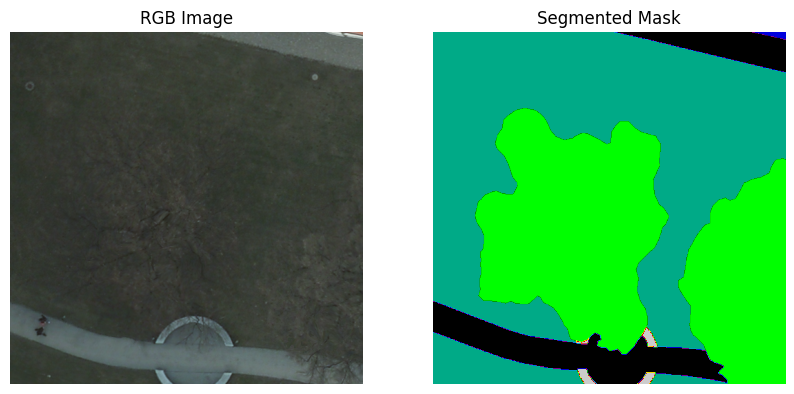

In [ ]:
# 📌 Import required libraries
import os
import json
import numpy as np
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Dataset paths (Update these if necessary)
images_csv = "/mnt/e/ISPRS-Potsdam-adri/split_postdam_ir_512/train/images.csv"
labels_csv = "/mnt/e/ISPRS-Potsdam-adri/split_postdam_ir_512/train/labels.csv"
classes_json = "/mnt/e/ISPRS-Potsdam-adri/postdam_classes.json"

# Load the classes mapping from JSON
with open(classes_json, 'r') as f:
    classes = json.load(f)

# Convert class colors to indices
color_to_index = {tuple(color): idx for idx, (class_name, color) in enumerate(classes.items())}

# Helper function to load image
def load_image(filename):
    return Image.open(filename)

# Function to convert a mask from RGB to class indices
def mask_to_class(mask, color_to_index):
    H, W, _ = mask.shape
    class_mask = np.zeros((H, W), dtype=np.int64)
    for color, idx in color_to_index.items():
        matches = np.all(mask == np.array(color), axis=-1)
        class_mask[matches] = idx
    return class_mask

# Function to get paths from CSV
import csv
def get_paths_from_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        paths = [Path(row[0]) for row in reader]
    return paths

# Load a random sample from dataset
image_paths = get_paths_from_csv(images_csv)
mask_paths = get_paths_from_csv(labels_csv)

# Select a random index
idx = np.random.randint(0, len(image_paths))

# Load the image and mask
img_path = image_paths[idx]
mask_path = mask_paths[idx]

# Ensure paths are correct
print(f"📂 Loading sample {idx}:")
print(f"🖼 Image path: {img_path}")
print(f"🎭 Mask path: {mask_path}")

# Open image and mask
image = load_image(img_path)
mask = load_image(mask_path)

# Print details
print(f"Image mode: {image.mode}, size: {image.size}")
print(f"Mask mode: {mask.mode}, size: {mask.size}")

# Convert images to numpy arrays
image_np = np.array(image)
mask_np = np.array(mask)

# Ensure the image has 4 channels (RGB + NIR)
if image_np.ndim == 2:
    print("⚠️ Warning: Image is grayscale, replicating channels...")
    image_np = np.stack([image_np] * 4, axis=-1)
elif image_np.shape[2] == 3:
    print("🔵 RGB image detected, adding NIR channel (zeros).")
    nir = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=image_np.dtype)
    image_np = np.concatenate([image_np, np.expand_dims(nir, axis=-1)], axis=-1)

# Ensure mask has 3 channels
if mask_np.ndim == 2:
    print("⚠️ Warning: Mask is grayscale, converting to RGB equivalent...")
    mask_np = np.stack([mask_np] * 3, axis=-1)

# Check final shapes
print(f"✅ Final Image Shape: {image_np.shape} (Should be H, W, 4)")
print(f"✅ Final Mask Shape: {mask_np.shape} (Should be H, W, 3)")

# Convert mask to class indices
print("Converting mask from RGB to class indices...")
mask_class = mask_to_class(mask_np, color_to_index)
print(f"Unique mask values: {np.unique(mask_class)}")

# Convert to PyTorch tensors
image_tensor = torch.tensor(image_np.transpose(2, 0, 1)).float() / 255.0  # Normalize 0-1
mask_tensor = torch.tensor(mask_class).long()

print(f"✅ Final Image Tensor Shape: {image_tensor.shape} (Should be 4, H, W)")
print(f"✅ Final Mask Tensor Shape: {mask_tensor.shape} (Should be H, W)")

# 🔍 Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_np[:, :, :3])  # Show RGB only
ax[0].set_title("RGB Image")
ax[0].axis("off")

ax[1].imshow(mask_class, cmap="nipy_spectral", vmin=0, vmax=len(classes) - 1)
ax[1].set_title("Segmented Mask")
ax[1].axis("off")

plt.show()